# Calibration of NTC thermistor

In [1]:
import numpy as np


T0 = 298.15


#Grove
Tref = 21.42 + 273.15

Rref = 1.1904
VG = 1023/(Rref+1) 
VGrel = VG/1023

BG = 4275


#NTC thermistor
R = 1.26829
VC = 1023/(R +1)
VCrel = VC/1023

BC = 1/(1/Tref-1/T0)*np.log(1/VCrel -1)

print("B-value of the NTC thermistor")
print(BC)

B-value of the NTC thermistor
5830.6076887593


uncertainty of T measurement of Grove Temp Sens

In [2]:
#uncertainty of the voltage reading
ures = (1/1023)**2


def uT(T, B, uB, s):
    #partial derivatives
    dTdB = T**2 * np.log(1/s-1) /B**2
    dTds =  T**2 * 1/(B*(1/s-1)) *1/s**2
    

    #propagated uncertaintly
    
    uT = dTdB**2*uB + dTds**2*ures

    return uT



uTG = uT(Tref, BG, 25**2, VGrel)

print("uncertainty of the Grove temperature reading")
print(np.sqrt(uTG))


uncertainty of the Grove temperature reading
0.08260119148860683


In [3]:
T = Tref
s = VCrel

dBdT = (1/T-1/T0)**(-2) * np.log(1/s-1)*1/T**2#np.log(1/s-1)*1/(1-2*T/T0 + (T/T0)**2)
dBds = -(1/T-1/T0)**(-1) *1/(1/s-1)/s**2#1/(1/T-1/T0)*1/(s*(s-1))


uBC = dBdT**2*uTG + dBds**2*ures

print("uncertainty of the NTC thermistor's B-value")
print(np.sqrt(uBC))

uncertainty of the NTC thermistor's B-value
167.3469028855914


In [4]:

uTC = uT(Tref, BC, uBC, VCrel)

print("Uncertainty of the NTC thermistor temperature reading")
print(np.sqrt(uTC))

Uncertainty of the NTC thermistor temperature reading
0.11742494463554821


# Heating

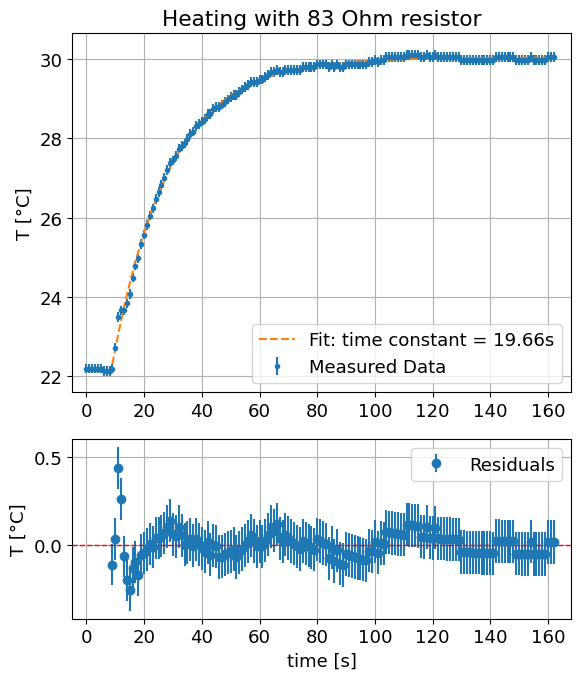

Chi-squared: 58.61
Degrees of freedom: 150
Reduced Chi-squared: 0.39
P-value: 1.0000000000


In [22]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 13})

# Read temperature from file
file_path = 'heating4_83ohm.txt'
with open(file_path, 'r') as file:
    temp_heating = [float(line.strip()) for line in file]
    temp_heating = np.array(temp_heating)
    
sigma_temp_heating = np.sqrt(uT(temp_heating+273.15, BC, uBC, VCrel))


def exponential_func(x, a, b, c, d):
    return a + b * np.exp(-c * (x-d))
    
start_index = 9
x_data = np.arange(start_index, len(temp_heating))
y_data = temp_heating[start_index:len(temp_heating)]
y_sigma = sigma_temp_heating[start_index:len(temp_heating)]


# Fit the exponential function to the data
p0 = [30, -10,0.1,8]
params, covariance = curve_fit(exponential_func, x_data, y_data, p0=p0, sigma=y_sigma)

# Extract the fitting parameters
a_fit, b_fit, c_fit, d_fit = params

# Generate y values based on the fitted exponential curve
y_fit = exponential_func(x_data, a_fit, b_fit, c_fit, d_fit)

# Calculate residuals
residuals = y_data - y_fit

# Create the main plot and the residual subplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 7), gridspec_kw={'height_ratios': [2, 1]})

# Main plot
ax1.errorbar(np.arange(len(temp_heating)), temp_heating, yerr=sigma_temp_heating, label='Measured Data', ms=3, fmt='o')
ax1.plot(x_data, y_fit, label=f'Fit: time constant = {(1/c_fit):.2f}s', linestyle='--')
ax1.set_ylabel('T [°C]')
ax1.set_title('Heating with 83 Ohm resistor')
ax1.set_xlim([-5, len(temp_heating)+5])
ax1.grid(True)
ax1.legend()

# Residual plot
ax2.errorbar(x_data, residuals, yerr=y_sigma, fmt='o', label='Residuals')
ax2.axhline(0, color='red', linestyle='--', linewidth=1)
ax2.set_xlabel('time [s]')
ax2.set_ylabel('T [°C]')
ax2.set_xlim([-5, len(temp_heating)+5])

ax2.grid(True)
ax2.legend()

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('Heating_with_residuals.pdf')
plt.show()

# reduced chi-squared test
chi_squared = np.sum((residuals/y_sigma) ** 2)
degrees_of_freedom = len(y_data) - len(params)
reduced_chi_squared = chi_squared / degrees_of_freedom

print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of freedom: {degrees_of_freedom}")
print(f"Reduced Chi-squared: {reduced_chi_squared:.2f}")


import scipy.stats as stats

p_value = stats.chi2.sf(chi_squared, degrees_of_freedom)
print(f"P-value: {p_value:.10f}")


# 2 point control

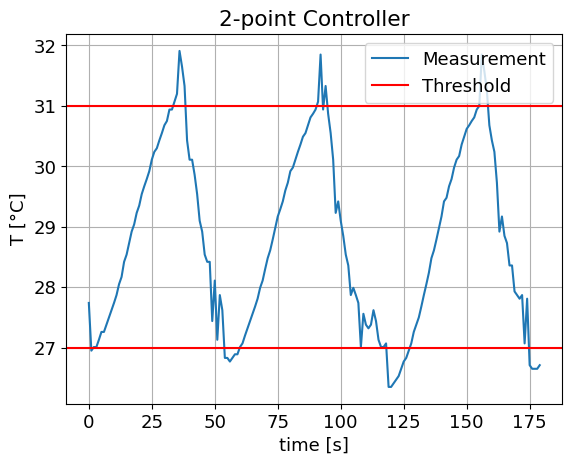

In [6]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


file_path = '2pointcontrol.txt'

# Read temperature from file
with open(file_path, 'r') as file:
    temperature = [float(line.strip()) for line in file]

plt.plot(temperature, label='Measurement')
plt.xlabel('time [s]')
plt.ylabel('T [°C]')
plt.axhline(y=31, color='r', linestyle='-', label='Threshold')
plt.axhline(y=27, color='r', linestyle='-')

plt.title('2-point Controller')
plt.grid(True)
plt.legend()
plt.savefig('2pointcontroller.pdf')
plt.show()


# dutycycle vs rpm

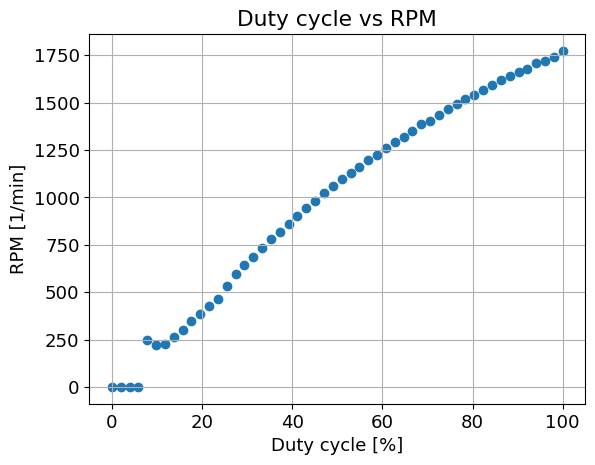

In [14]:
import matplotlib.pyplot as plt

# Replace 'your_file.txt' with the path to your file
file_path = 'dc_vs_rpm.txt'

# Read x and y values from the file
x_values = []
y_values = []

with open(file_path, 'r') as file:
    for line in file:
        x, y = map(float, line.strip().split())
        y_values.append(x)
        x_values.append(y*100/255)


# Plot y vs x
plt.scatter(x_values, y_values, label='Data Points')
plt.xlabel('Duty cycle [%]')
plt.ylabel('RPM [1/min]')
plt.title('Duty cycle vs RPM')
plt.grid(True)
#plt.legend()
plt.savefig('dutycyclevsrpm.pdf')
plt.show()


# Equilibrium temperature vs Dutycycle

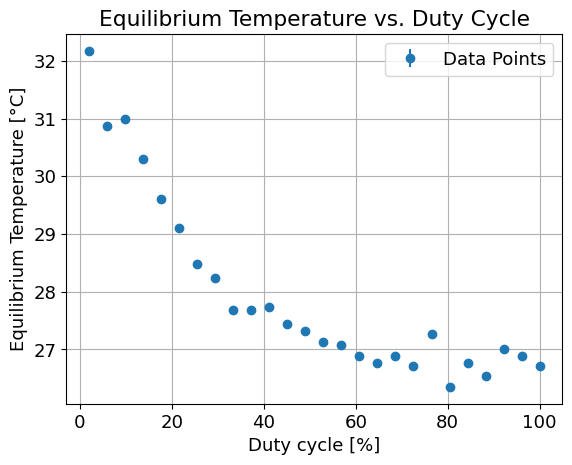

In [16]:
import matplotlib.pyplot as plt

# Replace 'your_file.txt' with the path to your file
file_path = 'eqTemp.txt'

# Read x and y values from the file
x_values = []
y_values = []
z_values = []

with open(file_path, 'r') as file:
    for line in file:
        x, y, z = map(float, line.strip().split())
        y_values.append(x)
        x_values.append(y*100/255)
        z_values.append(z)

x_values = np.array(x_values)
y_values = np.array(y_values)
z_values = np.array(z_values)
z_error = np.sqrt(uT(z_values, BC, uBC, VCrel))

# Plot y vs x
plt.errorbar(x_values, z_values, yerr=z_error, label='Data Points', fmt="o")
plt.xlabel('Duty cycle [%]')
plt.ylabel('Equilibrium Temperature [°C]')
plt.title('Equilibrium Temperature vs. Duty Cycle')
plt.grid(True)
plt.legend()
#plt.legend()
plt.savefig('eqtempvsdutycycle.pdf')
plt.show()


# PID control

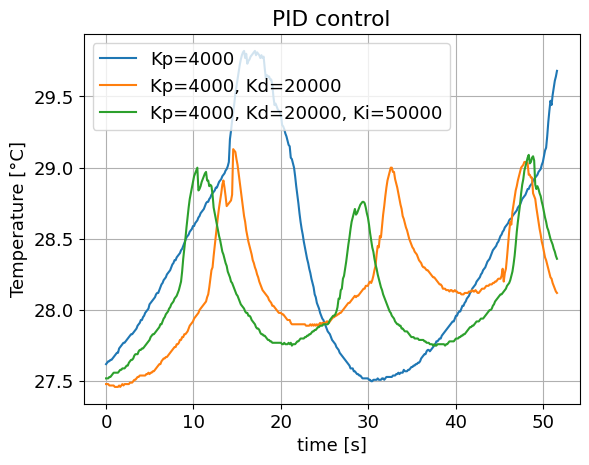

In [9]:
import matplotlib.pyplot as plt

# Replace 'your_file.txt' with the path to your file
file_path = 'PIDins_Kp4000.txt'

# Read x and y values from the file
x1 = []
y1 = []
z1 = []

with open(file_path, 'r') as file:
    for line in file:
        x, y, z = map(float, line.strip().split())
        y1.append(x)
        x1.append(y*100/255)
        z1.append(z)

# Replace 'your_file.txt' with the path to your file
file_path = 'PIDins_Kp4000_Kd20000.txt'

# Read x and y values from the file
x2 = []
y2 = []
z2 = []

with open(file_path, 'r') as file:
    for line in file:
        x, y, z = map(float, line.strip().split())
        y2.append(x)
        x2.append(y*100/255)
        z2.append(z)

# Replace 'your_file.txt' with the path to your file
file_path = 'PIDins_Kp4000_Kd20000_Ki50000.txt'

# Read x and y values from the file
x3 = []
y3 = []
z3 = []

with open(file_path, 'r') as file:
    for line in file:
        x, y, z = map(float, line.strip().split())
        y3.append(x)
        x3.append(y*100/255)
        z3.append(z)

# Plot y vs x
x = np.linspace(0,51.6,416)
plt.plot(x,y1[100:516], label='Kp=4000')
plt.plot(x,y2[100:516], label='Kp=4000, Kd=20000')
plt.plot(x,y3[100:516], label='Kp=4000, Kd=20000, Ki=50000')


plt.xlabel('time [s]')
plt.ylabel('Temperature [°C]')
plt.title('PID control')
plt.grid(True)
plt.legend()
plt.savefig('pidcontrol.pdf')
plt.show()
